In [3]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd

# replace with your actual file name after upload
DATA_PATH = "network_logs.csv"

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head(10)


Saving network_logs.csv to network_logs (1).csv
Shape: (5000, 7)


,timestamp,src_ip,dest_ip,protocol,bytes,threat_label,message
0,2025-01-04 20:52:29,192.168.1.230,10.0.0.167,HTTP,4182,benign,Normal network activity
1,2025-01-02 13:45:55,192.168.1.83,10.0.0.28,HTTP,90,benign,Normal network activity
2,2025-01-06 19:04:09,192.168.1.7,10.0.0.26,HTTPS,5795,benign,Normal network activity
3,2025-01-12 19:17:40,192.168.1.127,10.0.0.182,TCP,9233,benign,Normal network activity
4,2025-01-10 10:08:00,192.168.1.46,10.0.0.170,HTTPS,8111,benign,Normal network activity
5,2025-01-01 13:13:25,192.168.1.14,10.0.0.122,HTTPS,177,benign,Normal network activity
6,2025-01-13 22:51:31,192.168.1.185,10.0.0.61,UDP,2249,benign,Normal network activity
7,2025-01-01 10:01:53,192.168.1.85,10.0.0.124,HTTPS,1993,benign,Normal network activity
8,2025-01-19 04:55:05,192.168.1.132,10.0.0.215,TCP,2313,benign,Normal network activity
9,2025-01-22 14:33:04,192.168.1.27,10.0.0.179,HTTPS,1178,malicious,Potential phishing attempt


In [4]:
# Ensure timestamp is datetime
if "timestamp" in df.columns:
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")

print(df.info())
print("\nColumn samples:")
for c in df.columns[:12]:
    print(f"- {c}:", df[c].dropna().iloc[:3].to_list())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     5000 non-null   datetime64[ns]
 1   src_ip        5000 non-null   object        
 2   dest_ip       5000 non-null   object        
 3   protocol      5000 non-null   object        
 4   bytes         5000 non-null   int64         
 5   threat_label  5000 non-null   object        
 6   message       5000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 273.6+ KB
None

Column samples:
- timestamp: [Timestamp('2025-01-04 20:52:29'), Timestamp('2025-01-02 13:45:55'), Timestamp('2025-01-06 19:04:09')]
- src_ip: ['192.168.1.230', '192.168.1.83', '192.168.1.7']
- dest_ip: ['10.0.0.167', '10.0.0.28', '10.0.0.26']
- protocol: ['HTTP', 'HTTP', 'HTTPS']
- bytes: [4182, 90, 5795]
- threat_label: ['benign', 'benign', 'benign']
- message: ['

,missing
timestamp,0
src_ip,0
dest_ip,0
protocol,0
bytes,0
threat_label,0
message,0


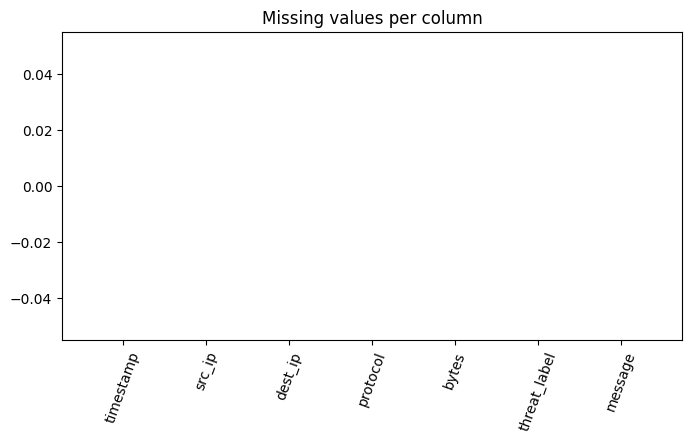

In [7]:
import matplotlib.pyplot as plt

na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.to_frame("missing"))

na_ratio = (na_counts / len(df)).round(3)

plt.figure(figsize=(8,4))
plt.bar(na_counts.index.astype(str), na_counts.values)
plt.xticks(rotation=70)
plt.title("Missing values per column")
plt.show()


In [9]:
import numpy as np

df_clean = df.copy()

# Drop full-duplicate rows
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
print("Dropped duplicates:", before - len(df_clean))

# Strategy for numerics: fill with median
for c in df_clean.select_dtypes(include=[np.number]).columns:
    df_clean[c] = df_clean[c].fillna(df_clean[c].median())

# Strategy for objects: fill with mode (if exists)
for c in df_clean.select_dtypes(include=["object"]).columns:
    if df_clean[c].isna().any():
        df_clean[c] = df_clean[c].fillna(df_clean[c].mode().iloc[0])

df_clean = df_clean.reset_index(drop=True)
df_clean.head()


Dropped duplicates: 0


,timestamp,src_ip,dest_ip,protocol,bytes,threat_label,message
0,2025-01-04 20:52:29,192.168.1.230,10.0.0.167,HTTP,4182,benign,Normal network activity
1,2025-01-02 13:45:55,192.168.1.83,10.0.0.28,HTTP,90,benign,Normal network activity
2,2025-01-06 19:04:09,192.168.1.7,10.0.0.26,HTTPS,5795,benign,Normal network activity
3,2025-01-12 19:17:40,192.168.1.127,10.0.0.182,TCP,9233,benign,Normal network activity
4,2025-01-10 10:08:00,192.168.1.46,10.0.0.170,HTTPS,8111,benign,Normal network activity


threat_label
benign       4006
malicious     994
Name: count, dtype: int64


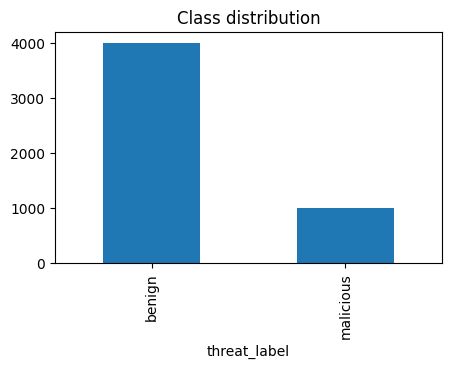

In [10]:
label_col = "threat_label"  # change if needed
print(df_clean[label_col].value_counts(dropna=False))

plt.figure(figsize=(5,3))
df_clean[label_col].value_counts().plot(kind="bar")
plt.title("Class distribution")
plt.show()


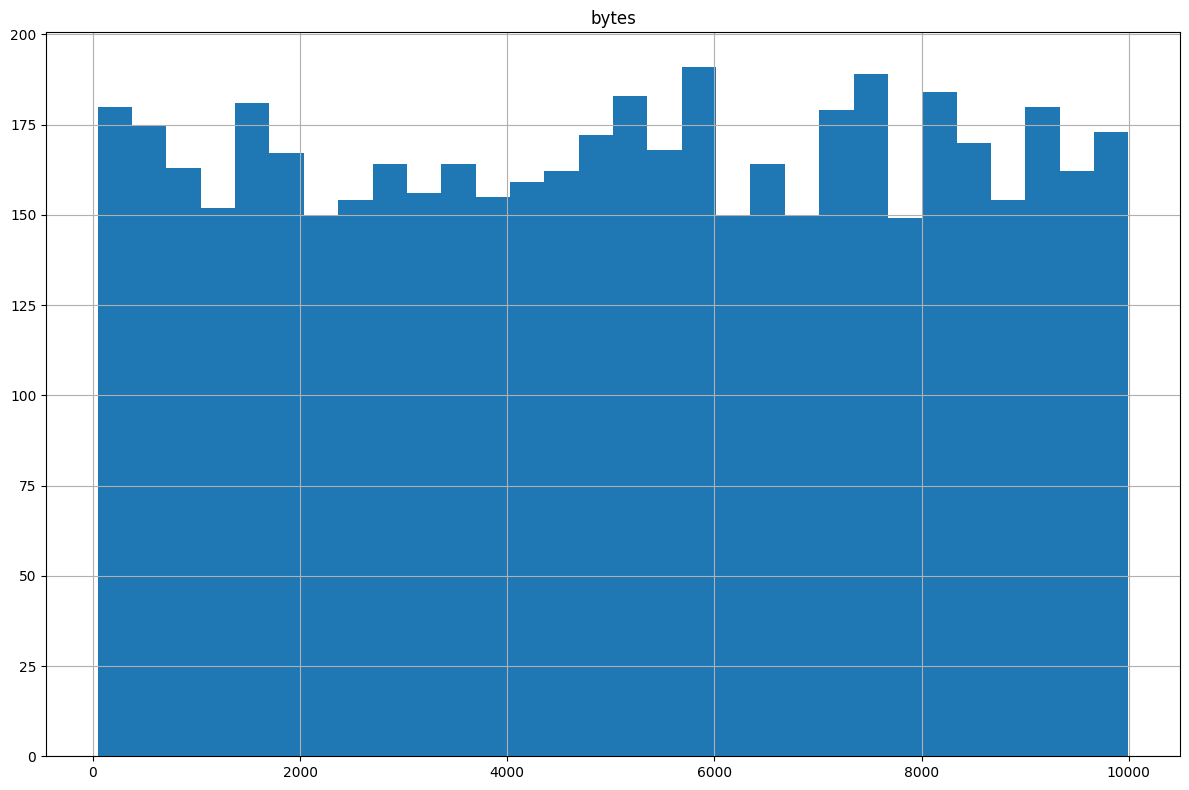

In [11]:
num_cols = [c for c in df_clean.select_dtypes(include=[np.number]).columns if c != label_col]
df_clean[num_cols].hist(figsize=(12,8), bins=30)
plt.tight_layout()
plt.show()



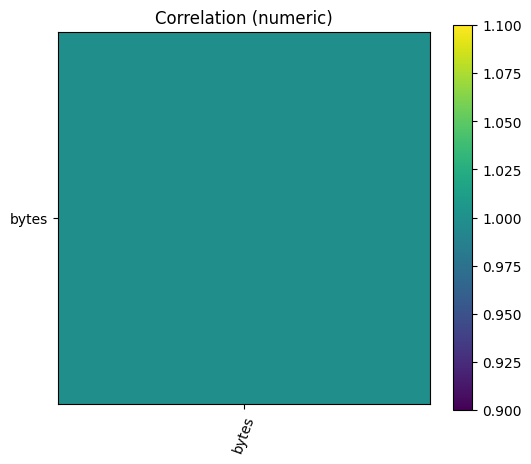

In [12]:
import numpy as np
corr = df_clean[num_cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(num_cols)), num_cols, rotation=70)
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Correlation (numeric)")
plt.colorbar()
plt.show()



In [13]:
fe = df_clean.copy()

# IP octets (rough signal)
import ipaddress
def ip_to_octets(ip):
    try:
        parts = str(ip).split(".")
        return [int(x) if x.isdigit() else 0 for x in (parts + [0,0,0,0])[:4]]
    except: return [0,0,0,0]

for col in ["src_ip", "dest_ip"]:
    if col in fe.columns:
        octs = fe[col].astype(str).apply(ip_to_octets).to_list()
        octs = np.array(octs)
        for i in range(4):
            fe[f"{col}_o{i+1}"] = octs[:,i]

# Protocol one-hot
if "protocol" in fe.columns:
    fe = pd.get_dummies(fe, columns=["protocol"], prefix="proto", drop_first=True)

# Time features
if "timestamp" in fe.columns:
    fe["hour"] = fe["timestamp"].dt.hour
    fe["dayofweek"] = fe["timestamp"].dt.dayofweek

fe.head()


,timestamp,src_ip,dest_ip,bytes,threat_label,message,src_ip_o1,src_ip_o2,src_ip_o3,src_ip_o4,dest_ip_o1,dest_ip_o2,dest_ip_o3,dest_ip_o4,proto_HTTPS,proto_ICMP,proto_TCP,proto_UDP,hour,dayofweek
0,2025-01-04 20:52:29,192.168.1.230,10.0.0.167,4182,benign,Normal network activity,192,168,1,230,10,0,0,167,False,False,False,False,20,5
1,2025-01-02 13:45:55,192.168.1.83,10.0.0.28,90,benign,Normal network activity,192,168,1,83,10,0,0,28,False,False,False,False,13,3
2,2025-01-06 19:04:09,192.168.1.7,10.0.0.26,5795,benign,Normal network activity,192,168,1,7,10,0,0,26,True,False,False,False,19,0
3,2025-01-12 19:17:40,192.168.1.127,10.0.0.182,9233,benign,Normal network activity,192,168,1,127,10,0,0,182,False,False,True,False,19,6
4,2025-01-10 10:08:00,192.168.1.46,10.0.0.170,8111,benign,Normal network activity,192,168,1,46,10,0,0,170,True,False,False,False,10,4


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
text_col = "message"  # change to your text field
has_text = text_col in fe.columns and fe[text_col].notna().any()

if has_text:
    tfidf = TfidfVectorizer(max_features=5000, stop_words="english")
    X_text = tfidf.fit_transform(fe[text_col].fillna(""))
    print("TF-IDF shape:", X_text.shape)
else:
    X_text = None
    print("No text column found or empty; skipping TF-IDF.")


TF-IDF shape: (5000, 14)


Graph nodes/edges: 508 1969


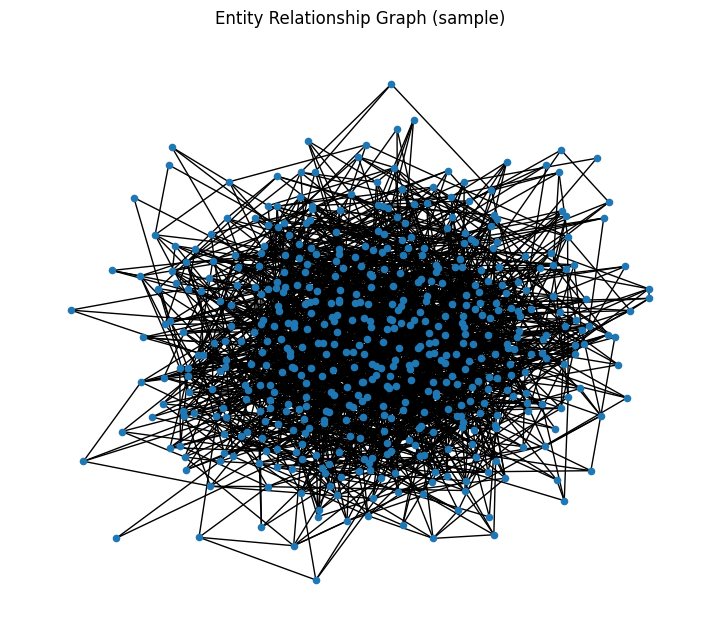

In [16]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

# fe అనేది మీ dataframe పేరు అయితే దాన్ని వాడండి
fe = df_clean   # లేకుంటే df_clean ను వాడండి

if set(["src_ip","dest_ip"]).issubset(fe.columns):
    edges = fe[["src_ip","dest_ip"]].dropna().head(2000).values.tolist()
    G.add_edges_from(edges)
    print("Graph nodes/edges:", G.number_of_nodes(), G.number_of_edges())

    plt.figure(figsize=(7,6))
    pos = nx.spring_layout(G, k=0.25, iterations=30, seed=7)
    nx.draw(G, pos, node_size=20, with_labels=False)
    plt.title("Entity Relationship Graph (sample)")
    plt.show()
else:
    print("No src_ip/dest_ip columns → skip graph.")


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

# Target encode
label_col = "threat_label"
le = LabelEncoder()
y = le.fit_transform(fe[label_col])   # benign=0, malicious=1

# Numeric features
X_num = fe.select_dtypes(include=[np.number]).drop(columns=[label_col], errors="ignore")

# Combine numeric + text if available
if "X_text" in locals() and X_text is not None:
    X = hstack([X_text, X_num.values])
else:
    X = X_num.values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape


((4000, 15), (1000, 15))

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Logistic Regression (handles sparse well)
logit = LogisticRegression(max_iter=200, n_jobs=-1 if hasattr(LogisticRegression, "n_jobs") else None)
logit.fit(X_train, y_train)

# Random Forest (on dense)
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
# convert to dense if sparse
Xtr_rf = X_train.toarray() if hasattr(X_train, "toarray") else X_train
Xte_rf = X_test.toarray() if hasattr(X_test, "toarray") else X_test
rf.fit(Xtr_rf, y_train)

print("Done training baseline models.")


Done training baseline models.


Logistic Regression:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       801
           1     1.0000    1.0000    1.0000       199

    accuracy                         1.0000      1000
   macro avg     1.0000    1.0000    1.0000      1000
weighted avg     1.0000    1.0000    1.0000      1000

Confusion matrix:
 [[801   0]
 [  0 199]]
ROC-AUC: 1.0


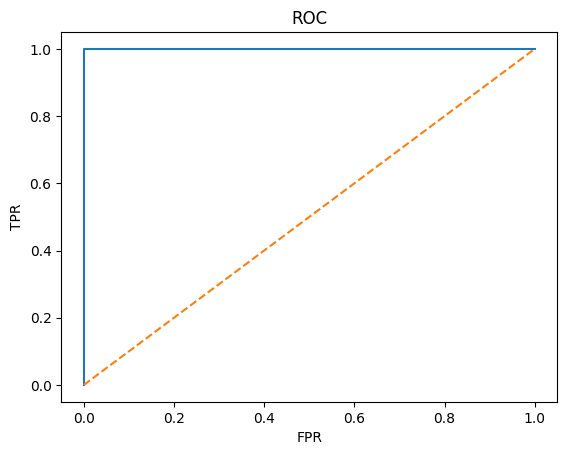


Random Forest:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       801
           1     1.0000    1.0000    1.0000       199

    accuracy                         1.0000      1000
   macro avg     1.0000    1.0000    1.0000      1000
weighted avg     1.0000    1.0000    1.0000      1000

Confusion matrix:
 [[801   0]
 [  0 199]]
ROC-AUC: 1.0


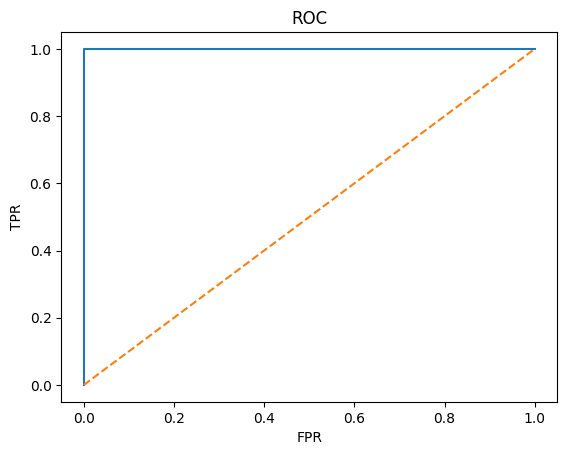

In [20]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import numpy as np

def eval_model(clf, Xtr, Xte):
    y_pred = clf.predict(Xte)
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)

    # ROC if proba available
    if hasattr(clf, "predict_proba"):
        proba = clf.predict_proba(Xte)[:,1]
    elif hasattr(clf, "decision_function"):
        proba = clf.decision_function(Xte)
    else:
        proba = None
    if proba is not None:
        auc = roc_auc_score(y_test, proba)
        fpr,tpr,_ = roc_curve(y_test, proba)
        print("ROC-AUC:", round(auc,4))
        plt.figure(); plt.plot(fpr,tpr); plt.plot([0,1],[0,1],'--'); plt.title("ROC")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

print("Logistic Regression:")
eval_model(logit, X_train, X_test)

print("\nRandom Forest:")
eval_model(rf, Xtr_rf, Xte_rf)


Balanced model trained.
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       801
           1     1.0000    1.0000    1.0000       199

    accuracy                         1.0000      1000
   macro avg     1.0000    1.0000    1.0000      1000
weighted avg     1.0000    1.0000    1.0000      1000

Confusion matrix:
 [[801   0]
 [  0 199]]
ROC-AUC: 1.0


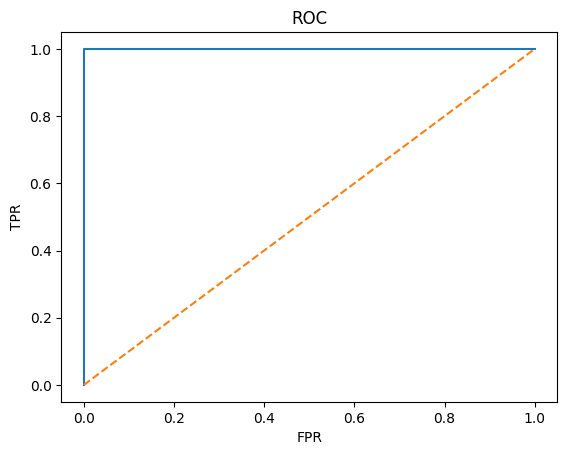

In [21]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier

Xtr = X_train if not hasattr(X_train, "toarray") else X_train.toarray()
Xte = X_test if not hasattr(X_test, "toarray") else X_test.toarray()

sm = SMOTE(random_state=42)
Xtr_sm, ytr_sm = sm.fit_resample(Xtr, y_train)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(Xtr_sm, ytr_sm)
print("Balanced model trained.")
eval_model(gb, Xtr_sm, Xte)


In [22]:
from sklearn.ensemble import IsolationForest

X_all = X_num.values  # unsupervised on numeric features
iso = IsolationForest(contamination=0.05, random_state=42)
scores = -iso.fit_predict(X_all)  # 1 (normal) / -1 (anomaly) → invert
fe["anomaly_flag"] = (scores == 2).astype(int)
fe[["anomaly_flag", label_col]].head(10)


,anomaly_flag,threat_label
0,0,benign
1,0,benign
2,0,benign
3,0,benign
4,0,benign
5,0,benign
6,0,benign
7,0,benign
8,0,benign
9,0,malicious


In [62]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

X_dense = X_num.astype("float32").values
Xtr_d, Xte_d = train_test_split(X_dense, test_size=0.2, random_state=42)

inp = keras.Input(shape=(Xtr_d.shape[1],))
enc = layers.Dense(64, activation="relu")(inp)
enc = layers.Dense(32, activation="relu")(enc)
dec = layers.Dense(64, activation="relu")(enc)
out = layers.Dense(Xtr_d.shape[1], activation=None)(dec)
ae = keras.Model(inp, out)
ae.compile(optimizer="adam", loss="mse")
hist = ae.fit(Xtr_d, Xtr_d, validation_data=(Xte_d, Xte_d), epochs=10, batch_size=256, verbose=0)

recon_error = np.mean((ae.predict(X_dense, verbose=0)-X_dense)**2, axis=1)
fe["ae_anomaly_score"] = (recon_error - recon_error.mean())/ (recon_error.std()+1e-9)
fe[["ae_anomaly_score"]].head()



,ae_anomaly_score
0,-0.595316
1,-0.995022
2,-0.065675
3,1.765528
4,1.062587


In [63]:
def predict_batch(new_df):
    tmp = new_df.copy()
    if "timestamp" in tmp:
        tmp["timestamp"] = pd.to_datetime(tmp["timestamp"], errors="coerce")
    if "protocol" in tmp:
        tmp = pd.get_dummies(tmp, columns=["protocol"], prefix="proto", drop_first=True)


    # Numeric features
    Xnew_num = tmp.reindex(columns=X_num.columns, fill_value=0)

    # Text features (if TF-IDF used during training)
    if "message" in tmp:
        Xnew_text = tfidf.transform(tmp["message"].fillna(""))
        from scipy.sparse import hstack
        Xnew = hstack([Xnew_text, Xnew_num.values])
    else:
        Xnew = Xnew_num.values

    yhat = rf.predict(Xnew)
    yproba = rf.predict_proba(Xnew)[:, 1]
    return yhat, yproba

    rf.fit(X_num, y)

sam shape: (500, 15)
shap_values type: <class 'numpy.ndarray'>
feature_names length: 15


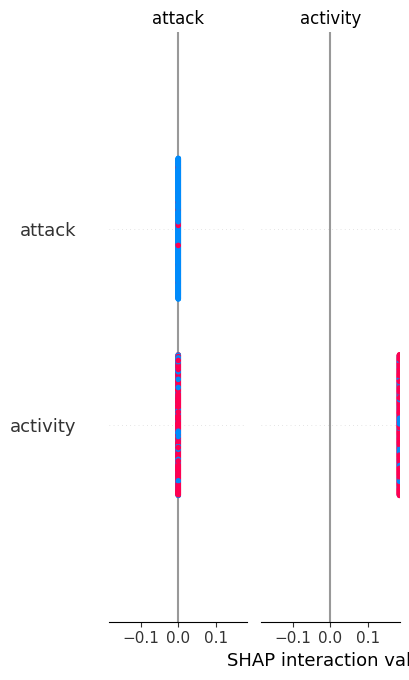

[0 1]


In [59]:
print("sam shape:", sam.shape)   # (500, ?)
print("shap_values type:", type(shap_values))
if isinstance(shap_values, list):
    for i, sv in enumerate(shap_values):
        print(f"class {i} shap_values shape:", sv.shape)
print("feature_names length:", len(all_features))


shap.summary_plot(
    shap_values,       # no indexing!
    sam,
    feature_names=all_features,
    plot_type="bar",
    show=True
)
print(rf.classes_)


In [46]:
import os
import joblib
import json

os.makedirs("/content/artifacts", exist_ok=True)

# Save model
joblib.dump(rf, "/content/artifacts/rf_model.pkl")

# Save feature column names
X_num.columns.to_series().to_csv("/content/artifacts/feature_columns.csv", index=False)

# Save metadata
with open("/content/artifacts/metadata.json", "w") as f:
    json.dump({"model": "RandomForest", "version": "1.0", "label_col": label_col}, f, indent=2)

print("Saved in /content/artifacts/")


Saved in /content/artifacts/


In [56]:
print("X_train shape:", X_train.shape)
print("Xtr_rf shape:", Xtr_rf.shape)
print("Model expects:", rf.n_features_in_)
rf.fit(X_train, y_train)

# Predict on correct test set
y_pred = rf.predict(X_test)   # not Xte_rf (unless you constructed it same as training)

print({
    "precision": float(precision_score(y_test, y_pred)),
    "recall": float(recall_score(y_test, y_pred)),
    "f1": float(f1_score(y_test, y_pred)),
    "test_size": int(len(y_test))
})


X_train shape: (4000, 15)
Xtr_rf shape: (4000, 15)
Model expects: 15
{'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'test_size': 1000}
